#Annual Water Use Prediction using simple regression

Author: Mehdi

Since we only have one month of water reporting for the current water year (october 2016), I will use a simple regression to estimate the total usage for 2016-2017 water year. I'll use the lower year for simplicity (i.e. water year 2014-2015 is 2014)

In [1]:
%pylab inline
import pandas as pd
from load_data import load_uw_supply_data
pd.options.display.max_columns=None

Populating the interactive namespace from numpy and matplotlib


/Users/bayesimpact/.virtualenvs/water/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


The helper function cleans up the data set and rename the columns.

In [70]:
df = load_uw_supply_data("../data/uw_supplier_data110116.xlsx")

I'll add month and year columns for easier reference.

In [102]:
df["month"] = df["reporting_month"].apply(lambda x: x.month)
df["year"] = df["reporting_month"].apply(lambda x: x.year)

I need total water use per capita for the month of october for all reported year. So far, I only have 2014 and 2015 in the data set. I'll produce a random number for october 2016 and use that number for my calculation. Once I receive the new dataset, I can replace that column.

In [149]:
df_oct_2015 = df.groupby("supplier_name").apply(lambda f: f[f["reporting_month"]==pd.Timestamp('2015-10-15')])["r_gpc"].reset_index().rename(columns={"r_gpc": "oct_2015"})
df_oct_2014 = df.groupby("supplier_name").apply(lambda f: f[f["reporting_month"]==pd.Timestamp('2014-10-15')])["r_gpc"].reset_index().rename(columns={"r_gpc": "oct_2014"})
new_df = pd.merge(df_oct_2015, df_oct_2014, left_on="supplier_name", right_on="supplier_name")[["supplier_name", "oct_2014", "oct_2015"]].set_index("supplier_name")
new_df["oct_2016"] = new_df.oct_2015.apply(lambda x: np.random.normal(x, 10))

I'll also need the total water use in 2014 and 2015 water year:

In [150]:
new_df["total_2014"] = df.groupby("supplier_name").apply(lambda f: f[f["reporting_month"] > pd.Timestamp('2014-10-14')][f["reporting_month"] < pd.Timestamp('2015-10-15')].r_gpc.sum())
new_df["total_2015"] = df.groupby("supplier_name").apply(lambda f: f[f["reporting_month"] > pd.Timestamp('2015-10-14')][f["reporting_month"] < pd.Timestamp('2016-10-15')].r_gpc.sum())

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from IPython.kernel.zmq import kernelapp as app


From these, I can predict 2015 and 2016 water year total use:

In [151]:
new_df["predict_2016"] = new_df.total_2015 * new_df.oct_2016 / new_df.oct_2015
new_df["predict_2015"] = new_df.total_2014 * new_df.oct_2015 / new_df.oct_2014
new_df["predict_2015_error"] = (new_df.predict_2015 - new_df.total_2015) / new_df.total_2015 * 100

In [146]:
new_df.head()

,oct_2014,oct_2015,total_2014,total_2015,oct_2016,predict_2016,predict_2015,predict_2015_error
supplier_name,,,,,,,,
Adelanto City of,68.00,87.90,994.34,824.56,80.139090,751.757542,1285.330676,55.880794
Alameda County Water District,74.90,68.40,808.60,809.10,64.224292,759.705764,738.427770,-8.734672
Alco Water Service,115.31,94.13,1231.10,1095.20,94.439604,1098.802239,1004.973055,-8.238399
Alhambra City of,104.90,93.10,1131.09,1050.52,102.499191,1156.578415,1003.855853,-4.442005
Amador Water Agency,77.00,62.00,748.96,777.08,69.680044,873.338209,603.058701,-22.394258


Let's look at our error in predicting the 2015 water use:

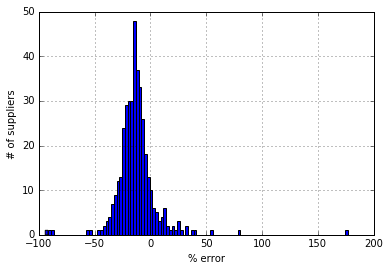

In [154]:
plt.figure()
ax = new_df.predict_2015_error.hist(bins=110)
ax.set_xlabel("% error")
_ = ax.set_ylabel("# of suppliers")

Looks like for majority of suppliers, our estimations for 2015 water year, are ~10% lower than the actual use.